### Building evasion vs. mean time interval : by Bus

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import datetime as dt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from Utils import TransantiagoConstants

In [3]:
periods_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/periods.xlsx"
first_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/1st_quarter.xlsx"
second_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/2nd_quarter.xlsx"
third_quarter_path = "C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/06_RFA/01_EvasionTrimestral/01_analisis/3rd_quarter.xlsx"

In [4]:
first_quarter_evasion = pd.read_excel(first_quarter_path, encoding = 'latin-1')
second_quarter_evasion = pd.read_excel(second_quarter_path, encoding = 'latin-1')
third_quarter_evasion = pd.read_excel(third_quarter_path, encoding = 'latin-1')
periods = pd.read_excel(periods_path)

In [5]:
first_quarter_evasion['TIEMPO'] = first_quarter_evasion['HORA'].astype(str)+':'+first_quarter_evasion['MINUTOS'].astype(str)+':00'
second_quarter_evasion['TIEMPO'] = second_quarter_evasion['HORA'].astype(str)+':'+second_quarter_evasion['MINUTOS'].astype(str)+':00'
third_quarter_evasion['TIEMPO'] = third_quarter_evasion['HORA'].astype(str)+':'+third_quarter_evasion['MINUTOS'].astype(str)+':00'

In [6]:
first_quarter_evasion.head()

,FECHA,SERVICIO,PLACA PATENTE,NUMERO DE PUERTAS,PUERTA NUMERO,LUGAR INICIO,HORA INICIO,HORA,MINUTOS,INGRESAN,NO VALIDAN,TP,TIEMPO
0,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,10,15,1,P,7:10:00
1,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,12,9,0,P,7:12:00
2,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,13,6,2,P,7:13:00
3,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,18,8,1,P,7:18:00
4,2017-01-10,214,BJFH98,3,1,AV. ADOLFO LOPEZ MATEO,07:10:00,7,20,5,1,P,7:20:00


In [7]:
first_quarter_evasion.columns = ['FECHA', 'SERVICIO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
second_quarter_evasion.columns = ['FECHA', 'SERVICIO','TIPO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
third_quarter_evasion.columns = ['FECHA', 'SERVICIO','PATENTE','PUERTAS','N_PUERTA','LUGAR_INICIO','HORA_INICIO','HORA','MINUTO','INGRESAN','NO_VALIDAN','TP','TIEMPO']
del second_quarter_evasion['TIPO']

In [8]:
type(first_quarter_evasion.loc[0,'TIEMPO'])

str

In [9]:
type(first_quarter_evasion.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

In [10]:
frames = [first_quarter_evasion, second_quarter_evasion, third_quarter_evasion]
evasion = pd.concat(frames, keys=['first', 'second', 'third'])

* Processing evasion-ddbb before merging

In [11]:
evasion['PATENTE'] =  evasion['PATENTE'].str.replace(' ','')
evasion_paradero = evasion[evasion['TP']=='P']
evasion_paradero_first = evasion_paradero[evasion_paradero['N_PUERTA']==1]

* Getting evasion by bus

In [12]:
summary = evasion_paradero_first.groupby(['FECHA','PATENTE'])['INGRESAN','NO_VALIDAN'].agg(['count','sum'])
summary.columns=['EVASION_COUNT', 'TOTAL_INGRESAN', 'tmp_count' ,'TOTAL_NO_VALIDAN']
del summary['tmp_count']
summary.reset_index(inplace=True)

* Building complete etapas ddbb.

In [13]:
common_dates = TransantiagoConstants.common_dates

In [14]:
reduced_etapas = pd.DataFrame()

for date in common_dates:
    base_input_path = 'C:/Users/leoca_000/Desktop/Evasion/01_analisis/03_datos/01_SSH/01_TIMESBYBUS/02_20SECS/'
    file_name = date + '-meanByBus.csv'
    grouped_by_bus = pd.read_csv(base_input_path+file_name, encoding = 'latin-1',sep =";")
    reduced_etapas = pd.concat([reduced_etapas,grouped_by_bus])


* Processing etapas ddbb before merging

In [15]:
del reduced_etapas['Unnamed: 0']
reduced_etapas = reduced_etapas.rename(columns = {'fecha':'FECHA', 'sitio_subida':'PATENTE', 'count': 'ETAPAS_COUNT'})
reduced_etapas['FECHA'] = pd.to_datetime(reduced_etapas.FECHA)
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace("-", "")
reduced_etapas['PATENTE'] = reduced_etapas['PATENTE'].str.replace(" ", "")

In [16]:
reduced_etapas.reset_index(drop=True,inplace=True)

In [17]:
type(reduced_etapas.loc[0,'FECHA'])

pandas._libs.tslib.Timestamp

* Merging.

In [18]:
evasion_vs_mean = pd.merge(summary,reduced_etapas, on=['FECHA','PATENTE'], how='left')

In [19]:
len(evasion_vs_mean.index)

1183

* Getting rid of missing values

In [20]:
clean_evasion_vs_mean = evasion_vs_mean[evasion_vs_mean['mean']>0]

In [21]:
len(clean_evasion_vs_mean.index)

495

* Computing evasion rate and if_turnstile

In [22]:
clean_evasion_vs_mean.loc[:,'EVASION_RATE'] = clean_evasion_vs_mean.loc[:,'TOTAL_NO_VALIDAN'] / clean_evasion_vs_mean.loc[:,'TOTAL_INGRESAN']

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
clean_evasion_vs_mean.loc[:,'fecha_instalacion'] = pd.to_datetime(clean_evasion_vs_mean.loc[:,'fecha_instalacion'])

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
clean_evasion_vs_mean.loc[:,'SI_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion'].notnull())

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
clean_evasion_vs_mean.loc[:,'SI_2017_TORNIQUETE'] = (clean_evasion_vs_mean.loc[:,'fecha_instalacion']>pd.to_datetime('2017-01-01'))

C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\leoca_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
clean_evasion_vs_mean_no_turnstile = clean_evasion_vs_mean[(clean_evasion_vs_mean['SI_TORNIQUETE']==False) | 
                                                           ((clean_evasion_vs_mean['SI_TORNIQUETE']==True) & (clean_evasion_vs_mean['FECHA']<=clean_evasion_vs_mean['fecha_instalacion']))]

In [27]:
len(clean_evasion_vs_mean_no_turnstile.index)

366

In [28]:
clean_evasion_vs_mean_no_turnstile.head()

,FECHA,PATENTE,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,ETAPAS_COUNT,sum,mean,fecha_instalacion,EVASION_RATE,SI_TORNIQUETE,SI_2017_TORNIQUETE
302,2017-03-09,BKWK90,49,94,27,340.0,937.0,2.755882,NaT,0.287234,False,False
303,2017-03-09,CJJH75,48,125,58,181.0,525.0,2.900552,2017-07-03,0.464000,True,True
304,2017-03-09,CJKC18,38,48,7,237.0,759.0,3.202532,2017-07-05,0.145833,True,True
305,2017-03-09,CJRG61,25,33,18,302.0,976.0,3.231788,NaT,0.545455,False,False
308,2017-03-09,FLXG78,44,79,16,221.0,634.0,2.868778,NaT,0.202532,False,False


In [29]:
clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].mean()

262.5327868852459

In [30]:
clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].min()

1.0

In [31]:
clean_evasion_vs_mean_no_turnstile[clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT']==1]

,FECHA,PATENTE,EVASION_COUNT,TOTAL_INGRESAN,TOTAL_NO_VALIDAN,ETAPAS_COUNT,sum,mean,fecha_instalacion,EVASION_RATE,SI_TORNIQUETE,SI_2017_TORNIQUETE
843,2017-07-13,CJRV32,7,9,0,1.0,8.0,8.0,NaT,0.0,False,False


In [32]:
clean_evasion_vs_mean_no_turnstile['ETAPAS_COUNT'].max()

815.0

In [33]:
clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].mean()

29.51912568306011

In [34]:
clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].min()

3

In [35]:
clean_evasion_vs_mean_no_turnstile['EVASION_COUNT'].max()

127

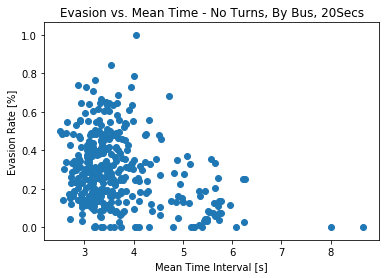

In [36]:
fig_1, ax_1 = plt.subplots()

ax_1.scatter(clean_evasion_vs_mean_no_turnstile['mean'],clean_evasion_vs_mean_no_turnstile['EVASION_RATE'])
ax_1.set_title('Evasion vs. Mean Time - No Turns, By Bus, 20Secs')
ax_1.set_xlabel('Mean Time Interval [s]')
ax_1.set_ylabel('Evasion Rate [%]')

#plt.savefig('C:/Users/Tesista/Desktop/Evasion/03_report/02_Figs/8_20Secs_EvasionVsMeanTimeByBus.pdf')

### Closed